1. mnist 이미지 분류

In [1]:
import zipfile
with zipfile.ZipFile('../data/mnist/dataset.zip') as zip_ref:
    zip_ref.extractall('../data/mnist/')

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1,data_home='../data/mnist', as_frame=False)

In [3]:
import numpy as np
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int64)
print(X.shape, y.shape)

(70000, 784) (70000,)


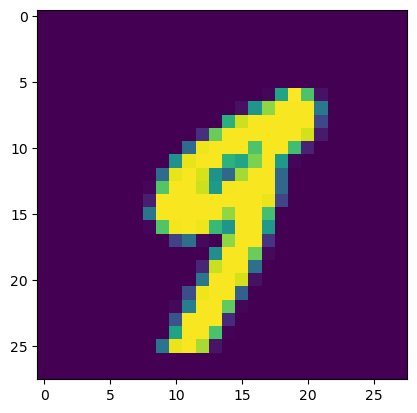

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image)
plt.show()

In [5]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary)
    plt.axis('off')

2

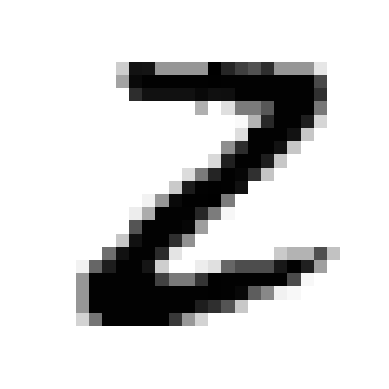

In [41]:
plot_digit(X[33333])
y[33333]

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

- 이진 분류기

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
# 확률적 경사하강법 분류모형(온라인학습)
# 확률적 경사하강법(Stochastic Gradient Descent, SGD)
# 무작위로 1개의 데이터를 추출하여 기울기를 계산
# 빠르게 최적점을 찾을 수 있는 알고리즘
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, random_state=0)
sgd_clf.fit(X_train, y_train_5)

c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=5, random_state=0)

In [13]:
sgd_clf.predict([some_digit])

array([False])

In [14]:
# 교차검증
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.9604 , 0.95685, 0.9632 ])

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# 클래스 비율이 유지되는 교차검증
skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # 분류모형을 복제(데이터는 복제하지 않음)
    clone_clf = clone(sgd_clf)
    # 학습용,검증용 구분
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    # 학습
    clone_clf.fit(X_train_folds, y_train_folds)
    # 분류
    y_pred = clone_clf.predict(X_test_folds)
    # 정확도
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.9604


c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.95685
0.9632


c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [16]:
# 모든 예측결과를 False로 리턴하는 테스트용 클래스
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        # 2원 영배열(행의수는 샘플개수), 0을 False로 리턴
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
print(never_5_clf.predict(X_train))
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')
# 정확도가 높음(이미지의 10%가 5이므로 5가 아니라고 분류하면 100-10=90% 정도의 정확도를 가짐)
# 이 모형은 좋은 모형이 아님, 특히 불균형 데이터셋의 경우 정확도는 큰 의미가 없을 수 있음

[[False]
 [False]
 [False]
 ...
 [False]
 [False]
 [False]]


array([0.90865, 0.9098 , 0.9105 ])

In [19]:
from sklearn.metrics import classification_report
print(classification_report(never_5_clf.predict(X_train), y_train_5))

              precision    recall  f1-score   support

       False       1.00      0.91      0.95     60000
        True       0.00      0.00      0.00         0

    accuracy                           0.91     60000
   macro avg       0.50      0.45      0.48     60000
weighted avg       1.00      0.91      0.95     60000



c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = sgd_clf.predict(X_train)

# 오차행렬
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

[[53422  1157]
 [ 1264  4157]]
53422 1157 1264 4157


In [21]:
from sklearn.metrics import precision_score, recall_score
# 정밀도 :TP / (TP + FP), 모형이 1로 분류한 것 중 실제로 1인 것의 비율
print(precision_score(y_train_5, y_train_pred))
print(tp/(tp+fp))

0.7822732404968009
0.7822732404968009


In [22]:
# 민감도(TPR, True Positive Rate) - 1을 1로 잘 맞춘 비율, 재현율(recall)이라고도 함
print(recall_score(y_train_5, y_train_pred))
print(tp/(tp+fn)) 

0.766832687695997
0.766832687695997


In [23]:
from sklearn.metrics import f1_score
# 정밀도와 재현율의 조화 평균
f1_score(y_train_5, y_train_pred)
# 정밀도와 재현율은 반비례하는 관계 : 정밀도를 높이면 재현율이 떨어지고 재현율이 높아지면 정밀도가 낮아짐
# 정밀도/재현율 트레이드오프라고 함

0.7744760130414531

In [24]:
# sgd 모형의 판별 함수
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-174278.21551795])

In [25]:
# 판별함수의 값 0을 기준으로 분류하는 함수
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # False로 분류됨

array([False])

In [26]:
# 판별함수의 결과값을 조절함
threshold = -417921
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [27]:
# 예측결과가 아닌 결정점수를 리턴하는 교차검증
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
print(y_scores)
print(y_scores.shape)

c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[-506637.15426888 -562031.80797363 -283879.23010011 ... -410321.51781743
 -886606.77296795 -256543.19056208]
(60000,)


c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


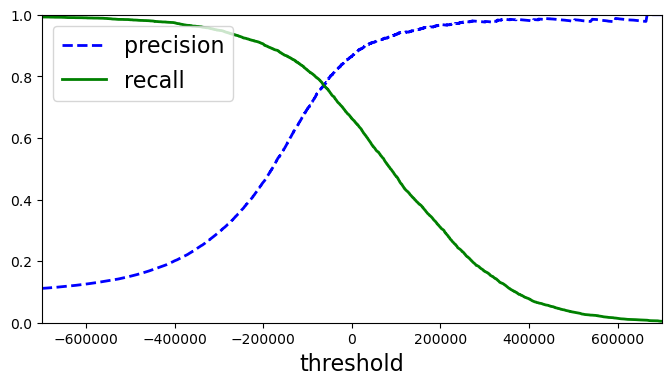

In [28]:
from sklearn.metrics import precision_recall_curve
# 판별함수의 결과값을 이용하여 모든 임계값에 대한 정밀도와 재현율 계산
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recall",linewidth=2)
    plt.xlabel("threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()
# 판별기준을 높이면 정밀도는 높아지고 재현율은 낮아짐
# 판별기준을 낮추면 정밀도는 낮아지고 재현율은 높아짐


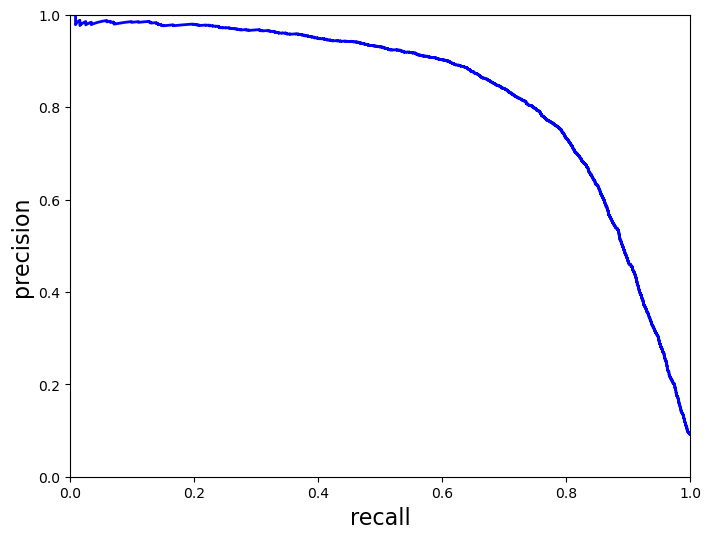

In [29]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.axis([0, 1, 0, 1])


plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()
# precision과 recall은 반비례 관계

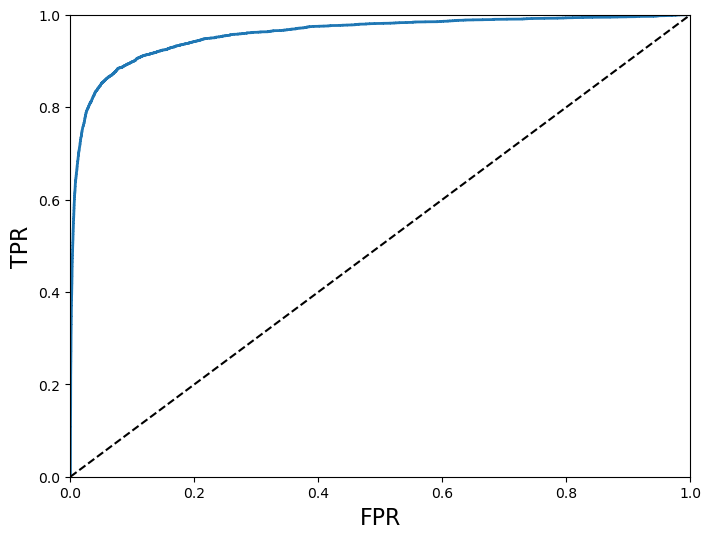

In [31]:
# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr,tpr)
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)
# 면적이 1에 가까울수록 완벽한 모형, 0.5이면 완전한 랜덤 분류기

0.9583907959569877

In [33]:
# sgd 모형과 비교하기 위하여 랜덤포레스트모형 추가
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)

# predict_proba : 랜덤포레스트에서 decision_function() 대신 제공되는 함수
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

In [34]:
y_probas_forest # 0일 확률, 1일 확률

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [35]:
y_scores_forest = y_probas_forest[:, 1] # 1일 확률
print(y_scores_forest)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

[0. 0. 0. ... 0. 0. 0.]


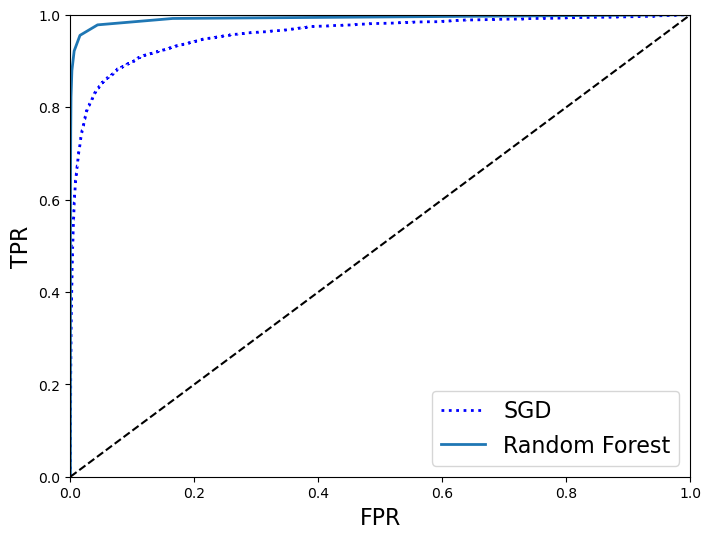

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [37]:
# sgd보다 랜덤포레스트 모형의 성능이 더 좋음
roc_auc_score(y_train_5, y_scores_forest)

0.9923793575737738

In [38]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9880292618044779

In [39]:
recall_score(y_train_5, y_train_pred_forest)

0.8221730308061244

- 다중 분류

In [42]:
# 다중분류를 위해 모든 데이터를 학습에 사용
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
# 내부적으로 10개의 이진분류기를 훈련시키고 각각의 결정점수를 비교하여 가장 점수가 높은 클래스를 선택함

c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([3], dtype=int64)

In [43]:
# 판별함수 확인, 클래스별로 10개의 점수가 출력됨
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

# 가장 높은 점수 출력
print(np.argmax(some_digit_scores))

# 라벨(클래스) 리스트
print(sgd_clf.classes_)

# 분류한 라벨 이름
print(sgd_clf.classes_[5])

[[-735505.98021904 -346192.4770047  -682240.64873165  -42557.714831
   -61471.55945201 -245277.27887537 -794685.32311802 -168075.05250792
  -277099.59922151 -206701.69961694]]
3
[0 1 2 3 4 5 6 7 8 9]
5


- 일대다전략과 일대일전략
- 일대다전략(one versus all, one versus the rest): 각 분류기의 결정점수 중에서 가장 높은 것을 선택하는 전략(0만 찾는 모형, 1만 찾는 모형, 대부분의 알고리즘에서 사용하는 방식)
- 일대일전략(one versus one): 0과 1, 0과 2 등으로 각 숫자의 조합마다 여러개의 모형을 만들어서 가장 성능이 좋은 모형을 채택하는 방식(svm에서 사용하는 방식)
- 사이킷런에서는 svm일 경우 OvO(일대일전략)을 다른 분류모형일 경우 OvA(일대다전략)을 선택함, 랜덤포레스트모형은 앙상블 모형이 므로 사이킷런의 OvA, OvO를 적용하지 않음

In [44]:
from sklearn.multiclass import OneVsOneClassifier
# 일대일전략을 사용하도록 지정하는 방법
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=0))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum

array([4], dtype=int64)

In [45]:
len(ovo_clf.estimators_) # 일대일전략에서 사용하는 분류기의 개수
pred = ovo_clf.predict(X_test)
np.mean(pred == y_test)

0.9179

In [46]:
from sklearn.multiclass import OneVsRestClassifier
# 1대다 전략(0과 1~9)
ovr_clf = OneVsRestClassifier(SGDClassifier(max_iter=5, random_state=10))
ovr_clf.fit(X_train, y_train)
len(ovr_clf.estimators_) # 분류기 개수
pred = ovr_clf.predict(X_test)
np.mean(pred == y_test)

c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum

0.8724

- 다중 레이블 분류

In [47]:
# 학습시간이 오래 걸림
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7) # 7,8,9
y_train_odd = (y_train % 2 == 1) # 홀수
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [48]:
knn_clf.predict([some_digit])
# 7,8,9에 해당되고 홀수이다

c:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[ True,  True]])